# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

## 1. Problem Definition

> How well can we predict the future sales price of a bulldozer, given its characteristic and previous sales data for similar bulldozers?

## 2. Data

The data is downloaded from the Kaggle Blue Book for Bulldozers competition: [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers/overview)

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale

There are several fields towards the end of the file on the different options a machine can have.  The descriptions all start with "machine configuration" in the data dictionary.  Some product types do not have a particular option, so all the records for that option variable will be null for that product type.  Also, some sources do not provide good option and/or hours data.

The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices. See [Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation).

**Note:** The goal is to minimize the RMSLE.

## 4. Features

Kaggle provides a data dictionary for the features.
See [Kaggle Data Dictionary](https://www.kaggle.com/c/bluebook-for-bulldozers/data).

## Imports And Data Exploration

In [122]:
# Regular EDA (exploratory data analysis) and plotting libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

# Models from Scikit-Learn
from sklearn.ensemble import RandomForestRegressor

# Model Evaluations
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

In [123]:
# import training
df = pd.read_csv('../../data/bulldozers/TrainAndValid.csv', low_memory=False)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [125]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [126]:
df.saledate.dtype

dtype('O')

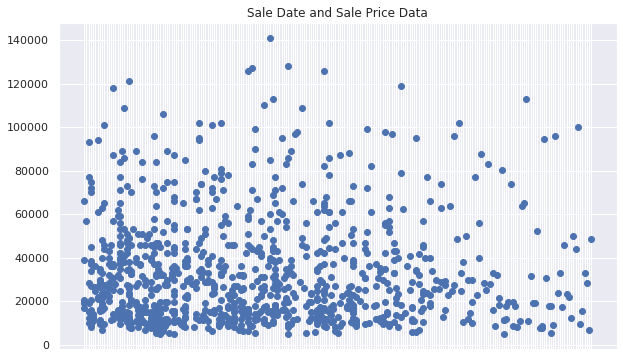

In [127]:
fig, ax = plt.subplots(figsize=(10,6))
scatter = ax.scatter(x=df['saledate'][:1000],
                    y=df['SalePrice'][:1000])
ax.set(title='Sale Date and Sale Price Data')
ax.set_xticklabels([]);

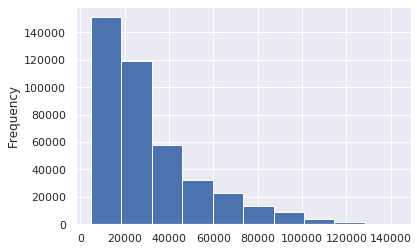

In [128]:
df.SalePrice.plot.hist();

### Parsing Dates

Time series data: enrich time & date component as much as possible -> use `parse_dates` parameter for pandas.

In [129]:
# import data again, but this time parse dates
df = pd.read_csv('../../data/bulldozers/TrainAndValid.csv',
                 low_memory=False,
                 parse_dates=['saledate'])

In [130]:
df.saledate.dtype

dtype('<M8[ns]')

In [131]:
df.saledate[:10]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

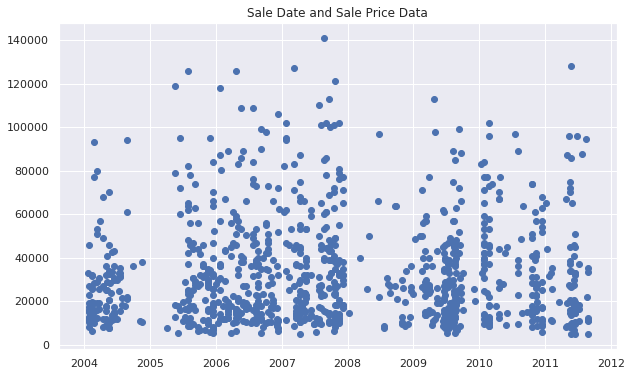

In [132]:
fig, ax = plt.subplots(figsize=(10,6))
scatter = ax.scatter(x=df['saledate'][:1000],
                    y=df['SalePrice'][:1000])
ax.set(title='Sale Date and Sale Price Data');

In [133]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [135]:
df.saledate.head(10)

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

## Sort DataFrame by saledate

When working with time series data, its a good idae to sort it by date.

In [136]:
# Sort DataFrame in date order
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df.saledate.head(10)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [137]:
# Make a copy
df_tmp = df.copy()

### Add datetime parameters for `saledate` column

In [138]:
df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day
df_tmp['saleDayOfWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayOfYear'] = df_tmp.saledate.dt.dayofyear

In [139]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [140]:
# Now we've enriched the DataFrame with datetime features, we can remove the saleDate column
df_tmp.drop('saledate', axis=1, inplace=True)

In [141]:
# Check the value of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [142]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


### Convert string to categories

One way to convert strings into numbers is by converting them into categories.

https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html

In [143]:
pd.api.types.is_string_dtype(df_tmp['UsageBand'])

True

In [144]:
# Find the columns which contain strings
[label for label, content in df_tmp.items() if pd.api.types.is_string_dtype(content)]

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls']

In [145]:
# Convert all columns with string values into category values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 1

In [147]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [148]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [149]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [150]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Now all columns that contained strings, have numerical values

But there's still missing data...

In [151]:
# Check missing data
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data

In [152]:
# Export current dmp dataframe
df_tmp.to_csv('../../data/bulldozers/train_and_valid_tmp.csv',
              index=False)

In [153]:
# Import preprocessed data
df_tmp = pd.read_csv('../../data/bulldozers/train_and_valid_tmp.csv',
                    low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


## Fill missing values

### Fill numeric values first

In [154]:
# Find the columns with numeric type
[label for label, content in df_tmp.items() if pd.api.types.is_numeric_dtype(content)]

['SalesID',
 'SalePrice',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'saleYear',
 'saleMonth',
 'saleDay',
 'saleDayOfWeek',
 'saleDayOfYear']

In [155]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [156]:
# Fill numeric null columns with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if data was missing
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [157]:
# Find the columns with numeric type
[label for label, content in df_tmp.items() if pd.api.types.is_numeric_dtype(content) if pd.isnull(content).sum()]

[]

In [158]:
# Check how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [159]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

### Filling categorical variables into numbers

In [160]:
# Find the columns with non-numeric type which have missing values
[(label, pd.isnull(content).sum()) for label, content in df_tmp.items() if not pd.api.types.is_numeric_dtype(content) if pd.isnull(content).sum()]

[('UsageBand', 339028),
 ('fiSecondaryDesc', 140727),
 ('fiModelSeries', 354031),
 ('fiModelDescriptor', 337882),
 ('ProductSize', 216605),
 ('Drive_System', 305611),
 ('Enclosure', 334),
 ('Forks', 214983),
 ('Pad_Type', 331602),
 ('Ride_Control', 259970),
 ('Stick', 331602),
 ('Transmission', 224691),
 ('Turbocharged', 331602),
 ('Blade_Extension', 386715),
 ('Blade_Width', 386715),
 ('Enclosure_Type', 386715),
 ('Engine_Horsepower', 386715),
 ('Hydraulics', 82565),
 ('Pushblock', 386715),
 ('Ripper', 305753),
 ('Scarifier', 386704),
 ('Tip_Control', 386715),
 ('Tire_Size', 315060),
 ('Coupler', 192019),
 ('Coupler_System', 367724),
 ('Grouser_Tracks', 367823),
 ('Hydraulics_Flow', 367823),
 ('Track_Type', 310505),
 ('Undercarriage_Pad_Width', 309782),
 ('Stick_Length', 310437),
 ('Thumb', 310366),
 ('Pattern_Changer', 310437),
 ('Grouser_Type', 310505),
 ('Backhoe_Mounting', 331986),
 ('Blade_Type', 330823),
 ('Travel_Controls', 330821),
 ('Differential_Type', 341134),
 ('Steering_C

In [161]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 59 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalesID                              412698 non-null  int64  
 1   SalePrice                            412698 non-null  float64
 2   MachineID                            412698 non-null  int64  
 3   ModelID                              412698 non-null  int64  
 4   datasource                           412698 non-null  int64  
 5   auctioneerID                         412698 non-null  float64
 6   YearMade                             412698 non-null  int64  
 7   MachineHoursCurrentMeter             412698 non-null  float64
 8   UsageBand                            73670 non-null   object 
 9   fiModelDesc                          412698 non-null  object 
 10  fiBaseModel                          412698 non-null  object 
 11  fiSecondaryDe

In [162]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes+1

In [163]:
pd.Categorical(df_tmp.state).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [164]:
pd.Categorical(df_tmp['UsageBand']).codes

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [165]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [166]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

## 5. Modelling

After some cursory EDA (you can always do more) let's start to do some model-driven EDA.

In [167]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

# Split data into X & y
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
X_valid, y_valid = df_val.drop('SalePrice', axis=1), df_val['SalePrice']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

## Building an evaluation function

In [168]:
# Create evaluation function RMSLE

def rmsle(y_true, y_pred):
    """
    Calculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Create function to evaluate model on a few different levels
def show_scores(model):
    """
    Shows scoring metrics for different data sets.
    """
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
              'Valid MAE': mean_absolute_error(y_valid, val_preds),
              'Training RMSLE': rmsle(y_train, train_preds),
              'Valid RMSLE': rmsle(y_valid, val_preds),
              'Training R^2': r2_score(y_train, train_preds),
              'Valid R^2': r2_score(y_valid, val_preds)}
    return scores

In [169]:
# Instantiate Random Forest Regressor with subset of data
rf_clf = RandomForestRegressor(n_jobs=-1,
                                 random_state=42,
                                 max_samples=10000)

In [170]:
%%time
rf_clf.fit(X_train, y_train)

CPU times: user 37.4 s, sys: 376 ms, total: 37.8 s
Wall time: 7.97 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [171]:
rf_clf_scores = show_scores(rf_clf)
rf_clf_scores

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

### Experiment with Reducing Features using PCA

In [172]:
# Make pipeline with PCA and RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=20, whiten=True, random_state=42)
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
pca_rf_model = make_pipeline(pca, rf)

In [173]:
pca_rf_model

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=20,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                      

In [174]:
# create hyperparameter grid for RandomForest
rf_param_grid = {'randomforestregressor__n_estimators': np.arange(10, 1000, 50),
                 'randomforestregressor__max_depth': [None, 3, 5, 10],
                 'randomforestregressor__min_samples_split': np.arange(2, 20, 2),
                 'randomforestregressor__min_samples_leaf': np.arange(1, 20, 2)}

rf_grid = RandomizedSearchCV(pca_rf_model, rf_param_grid, cv=5, n_iter=5, verbose=True)

In [175]:
# Fit data to grid
%time

rf_grid.fit(X_train[:1000], y_train[:1000])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   23.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=20,
                                                  random_state=42,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=True)),
                                             ('randomforestregressor',
                                              RandomForestRegressor(bootstrap=True,
                                                                    ccp_alpha=0.0,
                                                                    criterion='mse',
                                                                    max_depth=None,
                                    

In [176]:
rf_grid.best_params_

{'randomforestregressor__n_estimators': 810,
 'randomforestregressor__min_samples_split': 12,
 'randomforestregressor__min_samples_leaf': 3,
 'randomforestregressor__max_depth': None}

In [177]:
pca_rf_tuned_model = rf_grid.best_estimator_
pca_rf_tuned_model.score(X_valid, y_valid)

-0.17019931300778302

In [178]:
show_scores(pca_rf_tuned_model)

{'Training MAE': 24809.18946978096,
 'Valid MAE': 22755.248244448354,
 'Training RMSLE': 0.9219624860595013,
 'Valid RMSLE': 0.838134626644881,
 'Training R^2': -0.5583352180218186,
 'Valid R^2': -0.17019931300778302}

### Hyperparameter Tuning with RandomizedSearchCV

In [179]:
# Instantiate Random Forest Regressor with subset of data
rf_clf = RandomForestRegressor(n_jobs=-1,
                                 random_state=42)

In [180]:
# create hyperparameter grid for RandomForest
rf_param_grid = {'n_estimators': np.arange(10, 1000, 50),
                 'max_depth': [None, 3, 5, 10],
                 'min_samples_split': np.arange(2, 20, 2),
                 'min_samples_leaf': np.arange(1, 20, 2),
                 'max_features': [0.5, 1, 'sqrt', 'auto'],
                 'max_samples': [10000]}

rs_rf = RandomizedSearchCV(rf_clf,
                           rf_param_grid,
                           cv=2,
                           n_iter=5,
                           verbose=True)

In [181]:
# Fit model
%time

rs_rf.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.3min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [182]:
# Find the best parameters
rs_rf.best_estimator_, rs_rf.best_params_

(RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=10000, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=14, min_weight_fraction_leaf=0.0,
                       n_estimators=610, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False),
 {'n_estimators': 610,
  'min_samples_split': 14,
  'min_samples_leaf': 1,
  'max_samples': 10000,
  'max_features': 'auto',
  'max_depth': None})

In [183]:
# Set up tuned model with best params
rs_rf_best = rs_rf.best_estimator_

In [184]:
rs_rf_best_scores = show_scores(rs_rf_best)
rs_rf_best_scores

{'Training MAE': 5730.715269888247,
 'Valid MAE': 7246.59104136017,
 'Training RMSLE': 0.26349041935854295,
 'Valid RMSLE': 0.2952852433104515,
 'Training R^2': 0.8518858908624571,
 'Valid R^2': 0.8277028499042862}

### Train a Model With The Best (Given) Hyperparameters

**Note**: Found after 100 iterations by instructor of course.

In [185]:
%%time

# Ideal hyperparameters
ideal_rf = RandomForestRegressor(n_estimators=40,
                                 min_samples_leaf=1,
                                 min_samples_split=14,
                                 max_features=0.5,
                                 n_jobs=-1,
                                 max_samples=None,
                                 random_state=42)

# Fit the model
ideal_rf.fit(X_train, y_train)

CPU times: user 3min 57s, sys: 587 ms, total: 3min 57s
Wall time: 33.8 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [186]:
# Scores for ideal RandomForest model (trained on all the data)
show_scores(ideal_rf)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.24524163989538328,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

In [187]:
# Scores on rs_model (trained on subset of 10,000 rows)
rf_clf_scores

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

## Make predictions on test data

In [188]:
# Import test data
df_test = pd.read_csv('../../data/bulldozers/Test.csv',
                      low_memory=False,
                      parse_dates=['saledate'])

df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,1999,1000,2004,2006,2005
MachineHoursCurrentMeter,3688,28555,6038,8940,2286
UsageBand,Low,High,Medium,High,Low
saledate,2012-05-03 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00
fiModelDesc,580G,936,EC210BLC,330CL,650K


In [189]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

## Preprocessing test dataset

In [190]:
def preprocess_data(df):
    """
    Preprocess a dataset and returns transformed df.
    """
    # Add date columns, drop saledate
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    df.drop('saledate', axis=1, inplace=True)
    
    # Fill the numeric columns with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if data was missing
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
                
    # Fill categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            # Add binary column to indicate whether sample had missing value
            df[label+"_is_missing"] = pd.isnull(content)
            # Turn categories into numbers and add +1
            df[label] = pd.Categorical(content).codes+1
        
    return df

In [191]:
# Preprocesses test data
df_test_tmp = preprocess_data(df_test)
df_test_tmp.shape

(12457, 101)

In [192]:
# Try prediction
y_preds = ideal_rf.predict(df_test_tmp)

ValueError: Number of features of the model must match the input. Model n_features is 102 and input n_features is 101 

In [193]:
# Find different columns using sets
set(X_train.columns) - set(df_test_tmp.columns)

{'auctioneerID_is_missing'}

In [194]:
# Manually adjust df_test to have auctioneerID_is_missing_column
# (Test dataset had no missing auctioneerID)
df_test_tmp['auctioneerID_is_missing'] = False
df_test_tmp.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
...,...,...,...,...,...
Blade_Type_is_missing,True,True,True,True,False
Travel_Controls_is_missing,True,True,True,True,False
Differential_Type_is_missing,True,False,True,True,True
Steering_Controls_is_missing,True,False,True,True,True


Now test dataset has the same features as training dataset

In [195]:
# Make predictions on test data
test_preds = ideal_rf.predict(df_test_tmp)
test_preds

array([20614.36780887, 19897.80170658, 44852.21959446, ...,
       14296.98620472, 22164.85757662, 31683.80063427])

https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

Submission files should be formatted as follows:

* Have a header: "SalesID,SalePrice"
* Contain two columns
    * SalesID: SalesID for the validation set in sorted order
    * SalePrice: Your predicted price of the sale

In [196]:
# Format predictions into required Kaggle format
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test_tmp['SalesID']
df_preds['SalesPrice'] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,20614.367809
1,1227844,19897.801707
2,1227847,44852.219594
3,1227848,68346.325323
4,1227863,39487.349708
...,...,...
12452,6643171,46466.092910
12453,6643173,17500.493352
12454,6643184,14296.986205
12455,6643186,22164.857577


In [197]:
# Export prediction data
df_preds.to_csv('../../data/bulldozers/test_predictions.csv')

### Feature Importance

Feature importance seeks to figure out which attributes of the dat were the most important when it comes to predicting the **target variable** (SalePrice).

In [198]:
# Find feature importance of our best model
len(ideal_rf.feature_importances_)

102

In [199]:
len(X_train.columns)

102

In [200]:
# Helper function for plotting feature importance

def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features': columns,
                        'feature_importances': importances})
         .sort_values('feature_importances', ascending=False)
         .reset_index(drop=True))
    
    # Plot dataframe
    fig, ax = plt.subplots(figsize=(10,6))
    ax.barh(df.features[:n], df.feature_importances[:20])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature Importance')
    ax.invert_yaxis();

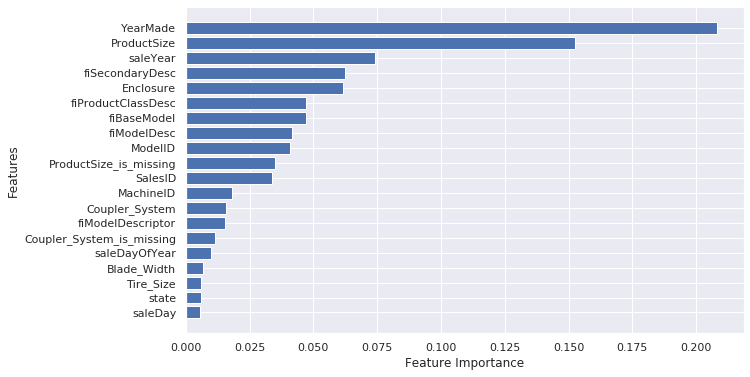

In [201]:
plot_features(X_train.columns, ideal_rf.feature_importances_)

In [202]:
df['ProductSize'].value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

In [203]:
df['fiSecondaryDesc'].value_counts()

C          44431
B          40165
G          37915
H          24729
E          21532
           ...  
STD            1
DC             1
CM             1
H              1
CKB            1
Name: fiSecondaryDesc, Length: 177, dtype: int64

In [204]:
df['Enclosure'].value_counts()

OROPS                  177971
EROPS                  141769
EROPS w AC              92601
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64

In [205]:
df_tmp['Coupler_System_is_missing'].value_counts()

True     367724
False     44974
Name: Coupler_System_is_missing, dtype: int64

## Correlation Matrix

In [206]:
# Create correlation matrix
corr_matrix = df_tmp.corr().abs()

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [207]:
# Drop features
df_dropped = df_tmp.drop(df_tmp[to_drop], axis=1)

In [208]:
df_dropped.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Enclosure_is_missing,Forks_is_missing,Ride_Control_is_missing,Ripper_is_missing,Tire_Size_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,False,False,False,False,False,False,True,True,False,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,False,False,False,False,False,False,False,True,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,False,False,False,False,False,False,True,True,False,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,False,False,False,False,False,False,False,True,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,False,False,False,False,False,True,True,False,True


In [209]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 63 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   SalesID                              412698 non-null  int64  
 1   SalePrice                            412698 non-null  float64
 2   MachineID                            412698 non-null  int64  
 3   ModelID                              412698 non-null  int64  
 4   datasource                           412698 non-null  int64  
 5   auctioneerID                         412698 non-null  float64
 6   YearMade                             412698 non-null  int64  
 7   MachineHoursCurrentMeter             412698 non-null  float64
 8   UsageBand                            412698 non-null  int8   
 9   fiModelDesc                          412698 non-null  int16  
 10  fiSecondaryDesc                      412698 non-null  int16  
 11  fiModelSeries

In [210]:
# Split data into training and validation
df_val = df_dropped[df_dropped.saleYear == 2012]
df_train = df_dropped[df_dropped.saleYear != 2012]

# Split data into X & y
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train['SalePrice']
X_valid, y_valid = df_val.drop('SalePrice', axis=1), df_val['SalePrice']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 62), (401125,), (11573, 62), (11573,))

In [211]:
# Instantiate Random Forest Regressor with subset of data
rf_clf = RandomForestRegressor(n_jobs=-1,
                                 random_state=42)

In [212]:
# create hyperparameter grid for RandomForest
rf_param_grid = {'n_estimators': np.arange(10, 1000, 50),
                 'max_depth': [None, 3, 5, 10],
                 'min_samples_split': np.arange(2, 20, 2),
                 'min_samples_leaf': np.arange(1, 20, 2),
                 'max_features': [0.5, 1, 'sqrt', 'auto'],
                 'max_samples': [10000]}

rs_rf_dropped = RandomizedSearchCV(rf_clf,
                                   rf_param_grid,
                                   cv=5,
                                   n_iter=100,
                                   verbose=True)

In [213]:
# Fit model
%time

rs_rf_dropped.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 74.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [214]:
rs_rf_dropped.best_params_, rs_rf_dropped.best_estimator_

({'n_estimators': 510,
  'min_samples_split': 2,
  'min_samples_leaf': 5,
  'max_samples': 10000,
  'max_features': 'auto',
  'max_depth': None},
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=10000, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=510, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False))

In [215]:
rs_rf_dropped_scores = show_scores(rs_rf_dropped)
rs_rf_dropped_scores

{'Training MAE': 5746.483737014149,
 'Valid MAE': 7269.665428045099,
 'Training RMSLE': 0.26417354315303576,
 'Valid RMSLE': 0.2927642470440483,
 'Training R^2': 0.8492786073823042,
 'Valid R^2': 0.8207743667729896}

### Preprocess test dataset for dropped correlated features

In [216]:
# Find different columns using sets
to_drop = list(set(df_test_tmp.columns) - set(X_train.columns))

In [217]:
# Drop those columns from test dataset
df_test_dropped = df_test_tmp.drop(to_drop, axis=1)
df_test_dropped.shape

(12457, 62)

In [218]:
# Make predictions on test data
test_preds = rs_rf_dropped.predict(df_test_dropped)
test_preds

array([19620.71696821, 23410.54384178, 52461.21346872, ...,
       11915.83153666, 16128.81741363, 23716.68497043])

In [219]:
# Format predictions into required Kaggle format
df_preds_dropped = pd.DataFrame()
df_preds_dropped['SalesID'] = df_test_tmp['SalesID']
df_preds_dropped['SalesPrice'] = test_preds
df_preds_dropped

,SalesID,SalesPrice
0,1227829,19620.716968
1,1227844,23410.543842
2,1227847,52461.213469
3,1227848,79473.789099
4,1227863,37988.234343
...,...,...
12452,6643171,47089.192789
12453,6643173,11738.457555
12454,6643184,11915.831537
12455,6643186,16128.817414


In [221]:
# Export prediction data
df_preds_dropped.to_csv('../../data/bulldozers/test_predictions_dropped_features.csv')